# Real time error mitigation in variational algorithms

In this tutorial we setup the training of a variational quantum eigensolver in a noisy environment. To deal with noise, we also apply a real-time error mitigation strategy with the intention of mitigating predictions and gradients during the training.

In [19]:
# We will use the pytorch interface
import torch
import numpy as np
import matplotlib.pyplot as plt

# Importing useful Qibo's modules
from qibo.noise import NoiseModel, PauliError
from qibo import hamiltonians, set_backend, hamiltonians
from qibo.backends import NumpyBackend

# And Qiboml's ones
import qiboml.interfaces.pytorch as pt
from qiboml.models.ansatze import HardwareEfficient
from qiboml.models.decoding import Expectation

set_backend("numpy")

[Qibo 0.2.20|INFO|2025-07-04 16:04:21]: Using numpy backend on /CPU:0


### Local Pauli noise model

First of all, we want to simulate a noisy environment. We are going to apply here a simple noise model to the simulation, which is known as _local Pauli noise channel_. In practice, we are going to randomly add Pauli operators ($X, Y, Z$) to each of our qubits everytime a gate is applied to our system. The core idea is that applying, those random parameters, we are randomly perturbating the evolution. For example, applying an $X$ gate we are simulating a random bit-flip in the state. Applying a $Z$, instead, we are randomly applying a phase flip. The $Y$, finally, will act as a combination of bit-flip and phase-flip. Overall, the impact of these perturbations will be to move the state of the system to be closer to the maximally [mixed state](https://en.wikipedia.org/wiki/Quantum_state#Mixed_states). We are going to use the Qibo formalism to construct and apply a noise model to our quantum circuit and we will tune the probability of applying these random Pauli operators as shown in the following function.

In [20]:
def build_noise_model(nqubits: int, local_pauli_noise_prob: float):
    """
    Construct a local Pauli noise channel.

    Args:
        nqubits (int): number of qubits of the circuit that will be target of this noise model.
        local_pauli_noise_prob (float): probability of applying the pauli channels.

    Returns:
        A Qibo `NoiseModel`
    """
    noise_model = NoiseModel()
    for q in range(nqubits):
        noise_model.add(
            PauliError(
                [
                    ("X", local_pauli_noise_prob),
                    ("Y", local_pauli_noise_prob),
                    ("Z", local_pauli_noise_prob),
                ]
            ),
            qubits=q,
        )
    return noise_model

Once the noise model is structured, we can start to build our quantum circuit. If you are not familiar with the concept of VQE, we recommend reading [this tutorial](https://github.com/qiboteam/qiboml/blob/main/tutorials/vqe.ipynb).

In this exercise, we will prepare the ground state of a non interacting Pauli Z Hamiltonian:
$$ H = - \sum_{i=1}^{N} Z_i.$$

As parametric quantum circuit, we decide to use an [Hardware Efficient Ansatz](https://www.nature.com/articles/nature23879).

In [59]:
# Define the target Hamiltonian and the VQE ansatz
nqubits = 3
circuit = HardwareEfficient(nqubits, nlayers=3, density_matrix=True)

Now we build the noise model using the function presented above.

In [60]:
noise_model = build_noise_model(nqubits=nqubits, local_pauli_noise_prob=0.008)

In Qiboml, we can pass the noise model as an argument of any decoder, and this will automatically execute our simulations with noise. 

---

> **Note**: the Qibo's default noise simulation is perfomed adopting the density matrix formalism, and this will inevitably slow down the circuit's execution.

---

### Training a VQE with noise

Now we can perform the training of our VQE in a noisy environment.

In [61]:
# Defining an Expectation decoding with noise model
noisy_decoding = Expectation(
    nqubits=nqubits,
    noise_model=noise_model,
    nshots=500,
    density_matrix=True,
    backend=NumpyBackend(),
)

# Completing the definition of the model
noisy_model = pt.QuantumModel(circuit_structure=[circuit,], decoding=noisy_decoding)

In [62]:
# This will take some time
optimizer = torch.optim.Adam(noisy_model.parameters(), lr=0.1)
noisy_losses = []
for iteration in range(100):
    optimizer.zero_grad()
    cost = noisy_model()
    noisy_losses.append(cost.item())
    cost.backward()
    optimizer.step()
    if iteration % 5 == 0:
        print(f"Iteration {iteration} |  Cost: {cost.item()}")

Iteration 0 |  Cost: 0.984000027179718
Iteration 5 |  Cost: -0.36000001430511475
Iteration 10 |  Cost: -1.0199999809265137
Iteration 15 |  Cost: -1.4279999732971191
Iteration 20 |  Cost: -1.5440000295639038
Iteration 25 |  Cost: -1.6319999694824219
Iteration 30 |  Cost: -1.600000023841858
Iteration 35 |  Cost: -1.715999960899353
Iteration 40 |  Cost: -1.8480000495910645
Iteration 45 |  Cost: -1.6799999475479126
Iteration 50 |  Cost: -1.8240000009536743
Iteration 55 |  Cost: -1.7719999551773071
Iteration 60 |  Cost: -1.7640000581741333
Iteration 65 |  Cost: -1.7960000038146973
Iteration 70 |  Cost: -1.7319999933242798
Iteration 75 |  Cost: -1.8040000200271606
Iteration 80 |  Cost: -1.8799999952316284
Iteration 85 |  Cost: -1.9160000085830688
Iteration 90 |  Cost: -1.7920000553131104
Iteration 95 |  Cost: -1.812000036239624


In [63]:
def plot_loss(noisy_loss, mit_loss=None):
    """Plot loss functions."""
    plt.figure(figsize=(5, 5 * 6/8))
    plt.hlines(
        -nqubits, 
        0, 
        len(noisy_loss), 
        label="Target energy", 
        color="black"
    )
    plt.plot(
        noisy_loss, 
        lw=2, 
        label="With noise", 
        color="red"
    )
    plt.xlabel("Iterations")
    plt.ylabel("Energy")
    if mit_loss is not None:
        plt.plot(
            mit_loss, 
            lw=2, 
            label="With noise and mitigation", 
            color="blue"
        )
        plt.legend()

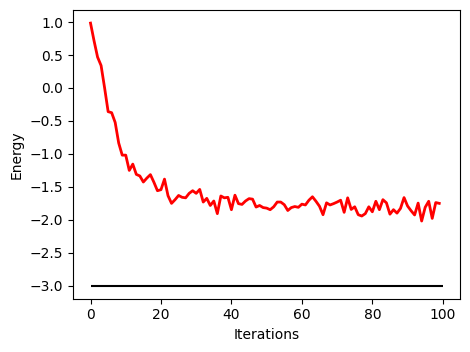

In [64]:
plot_loss(noisy_losses)

### Data driven error mitigation

The next step is to perform a real-time error mitigation. The strategy we follow here is the one presented in [this article](https://arxiv.org/abs/2311.05680).
In a few words, we adopt a _data-driven error mitigation_ technique, which consists in the following:

1. we consider a target circuit $\mathcal{C}^0$, which is typically difficult to simulate (in a real case scenario, here we are using four qubits as dummy example);
2. we construct a training set of circuits $\{\mathcal{C}^i_{\rm cdr} \}$ where a big portion of gates of the original circuits are replaced with Clifford gates. When a circuit is composed of a big quantity of Clifford gates is usually considered easier to simulate (See. [this paper](https://arxiv.org/abs/quant-ph/0406196) for references);
3. thanks to point 2., we can now compute both noisy and exact expectation values for all the circuits of the training set. These will be data that we can plot in a _noisy versus exact_ plane. For the exact values we use simulators (quasi-clifford simulators, hybrid stabilizers-MPO, etc), while the noisy values can be extracted from a noisy simulator or a real quantum device;
4. finally, we take all our data and we fit them with classical linear regression. We will have then a mitigation map $\ell$ (the equation of the line in the following figure), which can be used to mitigate any new expectation value!

<img src="./figures/cdr_scheme.png" width="600" height="500" alt="My Image">

### Real-time error mitigation

Here, we do quantum machine learning, and we therefore need to execute hundreds of circuits of the same size and type. Usually, in fact, we repeat many times the execution of the same ansatz to compute predictions, calculate gradients, or just repeat the procedure after the trainable parameters of our circuit have been updated by an optimizer.

It is clear, so, that it may not be necessary to repeat the mitigation procedure as many times as circuit executions! Better, it can happen that, for a considerable amount of time, the noise affecting our device remains stable. In those cases, we can compute the mitigation map just a few times and re-use it to mitigate dozens of expectation values.

#### How to know when I need to recompute the mitigation map?

To facilitate this task, Qiboml offers a `Mitigator` class, which takes care of the real-time mitigation procedure. Everytime a `Mitigator` object interacts with a Qiboml model, it constructs a reference target circuit which will be used to check whether a mitigation map is reliable or not. This reference circuit is purely Clifford, and it is built such that it is [error sensitive](https://www.nature.com/articles/s41534-023-00707-7) and easily simulable. Everytime we decide we want to check if the mitigation map is reliable, the reference circuit is executed on our noisy backend (simulation or hardware), and the final state is used to compute the target expectation value $\mathcal{E}_{\rm noisy}$. At this point, the mitigated value is computed using the currently cached mitigation map
$$ \mathcal{E}_{\rm mitigated} = \ell (\mathcal{E}_{\rm noisy}). $$
This mitigated value if finally used to evaluate a metric, which is simply 
$$ D = | \mathcal{E}_{\rm exact} - \mathcal{E}_{\rm mitigated} |. $$
The main idea, at this point, is that if $D$ exceeds some arbitrary chosen threshold value $\delta$, then the noise map is recomputed by executing one more time the whole data-driven error mitigation procedure.

#### Real-time error mitigation in Qiboml

The idea implemented here is that we can tune the real-time mitigation with two parameters:
1. we can set a `threshold` value $\delta$, which will be used as explained above;
2. we can set a `min_iterations` parameter, which defines the minimum numbers of calls to the decoder before we actually perform the checking procedure using our reference circuit.

In practice, our `Expectation` decoding accepts as argument a `mitigation_config` dictionary, where one can decide which type of strategy to implement. Let us describe briefly the possible way this configuration can be customized. In the following cell we define an example of configuration.

In [65]:
mitigation_config = {
    "threshold": 0.1,
    "min_iterations": 500,
    "method": "CDR",
    "method_kwargs": {"n_training_samples": 100, "nshots": 10000},
}

### Repeating the training with error mitigation

In [66]:
circuit = HardwareEfficient(nqubits, nlayers=3, density_matrix=True)

# Defining an Expectation decoding with noise model
# but also with error mitigation
mit_decoding = Expectation(
    nqubits=nqubits,
    noise_model=noise_model,
    nshots=500,
    density_matrix=True,
    backend=NumpyBackend(),
    mitigation_config=mitigation_config,
)

# Completing the definition of the model
mit_model = pt.QuantumModel(circuit_structure=[circuit,], decoding=mit_decoding)

In [67]:
# This will take some time
optimizer = torch.optim.Adam(mit_model.parameters(), lr=0.1)
mit_losses = []
for iteration in range(100):
    optimizer.zero_grad()
    cost = mit_model()
    mit_losses.append(cost.item())
    cost.backward()
    optimizer.step()
    if iteration % 10 == 0:
        print(f"Iteration {iteration} |  Cost: {cost.item()}")

[Qibo 0.2.20|INFO|2025-07-04 16:25:02]: Obtained noise map params: [ 1.79207917 -0.2017336 ].


Iteration 0 |  Cost: 0.7659891247749329
Iteration 10 |  Cost: -1.4561890363693237


[Qibo 0.2.20|INFO|2025-07-04 16:25:24]: Checking map since max iterations reached.
[Qibo 0.2.20|INFO|2025-07-04 16:25:28]: Obtained noise map params: [1.89325945 0.21027506].


Iteration 20 |  Cost: -2.9552547931671143


[Qibo 0.2.20|INFO|2025-07-04 16:25:50]: Checking map since max iterations reached.
[Qibo 0.2.20|INFO|2025-07-04 16:25:55]: Obtained noise map params: [1.82340815 0.3533521 ].


Iteration 30 |  Cost: -3.060067892074585


[Qibo 0.2.20|INFO|2025-07-04 16:26:17]: Checking map since max iterations reached.
[Qibo 0.2.20|INFO|2025-07-04 16:26:21]: Obtained noise map params: [ 1.28907343 -0.24243871].


Iteration 40 |  Cost: -2.9360761642456055
Iteration 50 |  Cost: -2.475113868713379


[Qibo 0.2.20|INFO|2025-07-04 16:26:43]: Checking map since max iterations reached.
[Qibo 0.2.20|INFO|2025-07-04 16:26:48]: Obtained noise map params: [1.52334206 0.0155354 ].


Iteration 60 |  Cost: -2.653359889984131


[Qibo 0.2.20|INFO|2025-07-04 16:27:09]: Checking map since max iterations reached.


Iteration 70 |  Cost: -2.6838266849517822
Iteration 80 |  Cost: -2.93365478515625


[Qibo 0.2.20|INFO|2025-07-04 16:27:31]: Checking map since max iterations reached.
[Qibo 0.2.20|INFO|2025-07-04 16:27:36]: Obtained noise map params: [1.94160983 0.55416519].


Iteration 90 |  Cost: -3.127126932144165


[Qibo 0.2.20|INFO|2025-07-04 16:27:58]: Checking map since max iterations reached.
[Qibo 0.2.20|INFO|2025-07-04 16:28:02]: Obtained noise map params: [1.9059589  0.47177321].


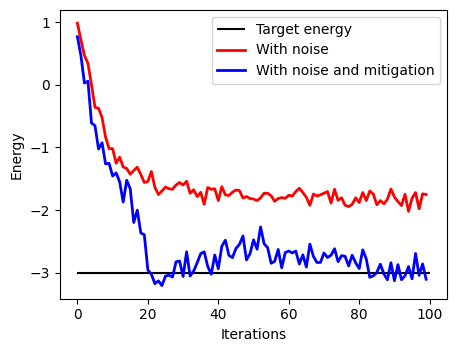

In [68]:
plot_loss(noisy_losses, mit_losses)

Paying a small overhead, we manage to reach a better approximation!